# Mathematical Underpinnings - Lab 3

  - A set $S_n = \{x_1, x_2, \ldots, x_n\}$ is **shattered** by a class $\mathcal{C}$ (or $\mathcal{C}$ shatters $S_n$) if $|\{S_n \cap c: c \in \mathcal{C}\}| = 2^n$.

  - **Shattering coefficient** of $\mathcal{C}$ is a number such that $\mathcal{S}_{\mathcal{C}}(n) = \max_{S_n} |\{S_n \cap c: c \in \mathcal{C}\}|$.

  - **Vapnik–Chervonenkis** dimension of $\mathcal{C}$ is $VC(\mathcal{C}) = \min_n \{n: \mathcal{S}_{\mathcal{C}}(n) < 2^n\}$.

*What to do if we have a class of functions $\mathcal{F}$ instead of a set of subsets $\mathcal{C}$*

  - **Subgraph** of a function $f$ is defined as $\textrm{Subgraph}(f) = \{x: f(x) \leq 0\}$.

  - Then $\mathcal{C}$ from the above definitions is defined as $\mathcal{C} = \{\textrm{Subgraph}(f): f \in \mathcal{F}\}$

  - **Example** for linear decision boundaries in $\mathbb{R}^2$: 
  
      A function: $f_b(x) = f_b(x^{1}, x^{2}) = b^{0} + b^{1}x^{1} + b^{2}x^{2}$
      
      A hyperplane (in $\mathbb{R}^2$ a line): $f_b(x^{1}, x^{2}) = b^{0} + b^{1}x^{1} + b^{2}x^{2} = 0$

      $\textrm{Subgraph}(f_b) = \{\textrm{A half space bounded by a hyperplane given above}\}$

      A family of functions: $\mathcal{F} = \{f_b: b \in \mathbb{R}^3\}$
  
      $\mathcal{C} = \{\textrm{All half spaces separated by all hyperplanes}\}$

## Task 1

### a)

Facts from the lecture:

  - If $\mathcal{F}_{a,b} = \{f: f(x) = a'x +b\}$ (a family of linear functions in $\mathbb{R}^d$), then $VC(\mathcal{F}_{a,b}) \leq d+2$.
  - If $\mathcal{F}_{a,b} = \{f: f(x) = a'x +b\}$ (a family of linear functions in $\mathbb{R}^d$), then $VC(\mathcal{F}_{a,b}) = d+1$.

Of course the second implies the first fact, but both are given as proving inequality is simpler (and we repeat what exactly was on the lecture).


*Pictures on paper*

### b)

In [32]:
from sklearn.svm import SVC
import numpy as np
from itertools import combinations

def generate_class_assignments(n):
    all_assignments = []
    for i in range(n + 1):
        for combo in combinations(range(n), i):
            assignment = [0] * n
            for index in combo:
                assignment[index] = 1
            all_assignments.append(assignment)
    return all_assignments

def is_linearly_separable(S_n, class_assignment):
    svm = SVC(C=10000, shrinking=False, kernel='linear', tol=1e-5)
    try:
        svm.fit(S_n, class_assignment)
        if np.array_equal(svm.predict(S_n), class_assignment):
            return True, svm.coef_[0], svm.intercept_[0]
    except ValueError:
        return False, None, None
    return False, None, None

def is_shattered(d, n, S_n):
    class_assignments = generate_class_assignments(n)
    
    for class_assignment in class_assignments:
        if len(np.unique(class_assignment)) == 1:
            continue
        linearly_separable, _, _ = is_linearly_separable(S_n, class_assignment)
        if not linearly_separable:
            return False
    return True

### c)

In [3]:
Sn = np.array([[0, 0], [1, 1], [2, 2], [3, 3]])
class_assignments = generate_class_assignments(len(Sn))

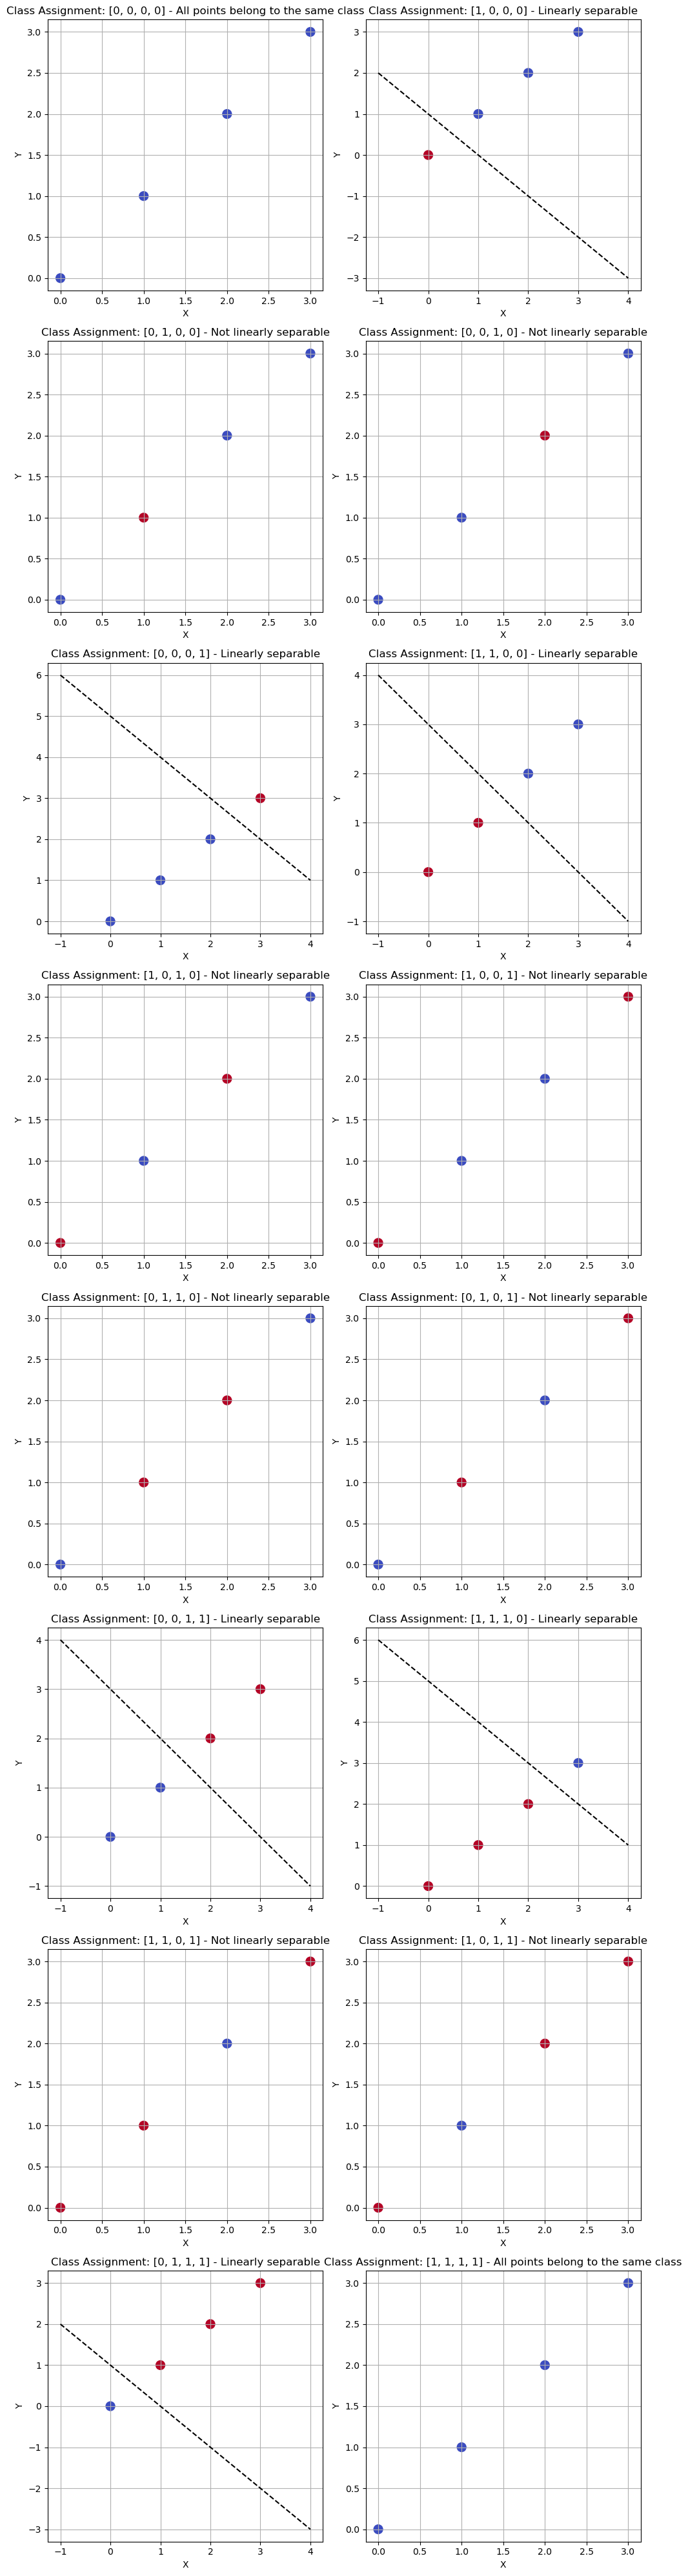

In [4]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(len(class_assignments)//2 + len(class_assignments)%2, 2, figsize=(10, 5 * (len(class_assignments)//2 + len(class_assignments)%2)))
for i, class_assignment in enumerate(class_assignments):
    row = i // 2
    col = i % 2
    ax = axs[row, col]
    ax.scatter(Sn[:, 0], Sn[:, 1], c=class_assignment, cmap='coolwarm', s=100)
    ax.set_title(f'Class Assignment: {class_assignment}')

    if len(np.unique(class_assignment)) == 1:
        ax.set_title(f'Class Assignment: {class_assignment} - All points belong to the same class')
    else:
        is_shattered_result, coef, intercept = is_linearly_separable(Sn, class_assignment)
        if is_shattered_result:
            ax.set_title(f'Class Assignment: {class_assignment} - Linearly separable')
            # Plot the decision boundary
            x_values = np.linspace(min(Sn[:, 0]) - 1, max(Sn[:, 0]) + 1, 100)
            y_values = (-coef[0] * x_values - intercept) / coef[1]
            ax.plot(x_values, y_values, color='black', linestyle='--', label='Decision Boundary')
        else:
            ax.set_title(f'Class Assignment: {class_assignment} - Not linearly separable')

    ax.grid(True)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')

plt.tight_layout()
plt.show()

### d)

In [90]:
import multiprocessing
from functools import partial

In [94]:
def estimate_vc_dimension_for_d(d, n_values, N):
    shattered_counts = []

    # for each value of n (number of points)
    for n in n_values:
        shattered_count = 0

        # repeat N times
        for _ in range(N):
            S_n = np.random.multivariate_normal(
                mean=np.zeros(d),
                cov=np.eye(d),
                size=n
            )

            # count how many times the set is shattered
            if is_shattered(d, n, S_n):
                shattered_count += 1

        # calculate the ratio of shattered sets
        shattered_counts.append(shattered_count)

    return n_values[
        np.where(np.array(shattered_counts) > 0)[0][-1]
    ]

def estimate_vc_dimension(d_values, n_values, N=50):
    vc_dimensions = []
    
    with multiprocessing.Pool() as pool:
        vc_dimensions = pool.map(
            partial(estimate_vc_dimension_for_d, n_values=n_values, N=N), 
            d_values
        )
        
    return vc_dimensions

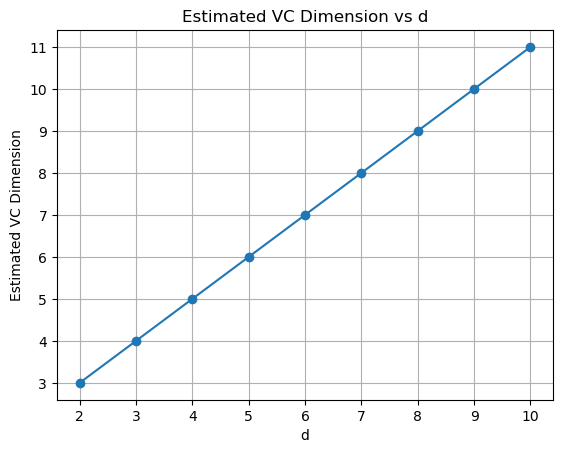

In [95]:
d_values = list(range(2, 11))
n_values = list(range(2, 13))

# reduced to N=5 for the sake of computation time
vc_dimensions = estimate_vc_dimension(d_values, n_values, N=5)

plt.plot(d_values, vc_dimensions, marker='o')
plt.title('Estimated VC Dimension vs d')
plt.xlabel('d')
plt.ylabel('Estimated VC Dimension')
plt.grid(True)
plt.show()

$$VC(\mathcal{F}_{a,b}) = d+1$$

### e)

In [ ]:
# A hint: change a kernel in SVM

In [115]:
# use rbf kernel
def is_linearly_separable_rbf(S_n, class_assignment):
    svm = SVC(C=10000, shrinking=False, kernel='rbf', tol=1e-5)
    try:
        svm.fit(S_n, class_assignment)
        if np.array_equal(svm.predict(S_n), class_assignment):
            return True
    except ValueError:
        return False
    return False

def is_shattered_rbf(d, n, S_n):
    class_assignments = generate_class_assignments(n)
    
    for class_assignment in class_assignments:
        if len(np.unique(class_assignment)) == 1:
            continue
        linearly_separable = is_linearly_separable_rbf(S_n, class_assignment)
        if not linearly_separable:
            return False
    return True

def estimate_vc_dimension_for_d_rbf(d, n_values, N):
    shattered_counts = []

    # for each value of n (number of points)
    for n in n_values:
        shattered_count = 0

        # repeat N times
        for _ in range(N):
            S_n = np.random.multivariate_normal(
                mean=np.zeros(d),
                cov=np.eye(d),
                size=n
            )

            # count how many times the set is shattered
            if is_shattered_rbf(d, n, S_n):
                shattered_count += 1

        # calculate the ratio of shattered sets
        shattered_counts.append(shattered_count)

    return n_values[
        np.where(np.array(shattered_counts) > 0)[0][-1]
    ]

In [118]:
estimate_vc_dimension_for_d_rbf(4, list(range(2, 10)), 5)

9